# `Poesidon-viewer` plot cutout demonstration

Make plots of dynamical variables and extract timeseries of heat and salt content for a specified control volume defined by a (lon,lat,depth) cutout. The (lon,lat) cutout locations are imported to the notebook from the `Poseidon-viewer`.

This notebook:

* Demonstrates the interface to the `Poseidon-viewer` on SciServer
* Uses the [oceanspy](https://oceanspy.readthedocs.io/en/latest/) `compute` methods to compute dynamical quantities.
* Makes plots showing the location of the specified cutout and heat and salt content timeseries within it.

Author: Tom Haine, Miguel Jimenez-Urias, Mitya Medvedev: Jul, Dec '23

In [1]:
import oceanspy as ospy
# from oceanspy.llc_rearrange import Dims, LLCtransformation
from oceanspy.utils import viewer_to_range
from shapely.geometry import Polygon, Point, MultiPolygon, shape

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

print(ospy.__version__)      # Version information

0.3.5.dev18+gc9ba7bc


In [2]:
from dask.distributed import Client
client = Client()

/home/idies/mambaforge/envs/Oceanography/lib/python3.10/contextlib.py:142: UserWarning: Creating scratch directories is taking a surprisingly long time. (1.03s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


### Pick the model dataset here, and the time of interest.

* `ECCO` is quick, coarse resolution, and good for initial exploration and to test very large cutouts and long timeseries.
* `LLC4320` is slow, high resolution, and good for final figures and for small cutouts and short timeseries.

See the [Poseidon datasets](https://www.poseidon-ocean.net/products/datasets/) for more details.

In [3]:
OGCM_dataset = 'ECCO'
# OGCM_dataset = 'LLC4320'
od = ospy.open_oceandataset.from_catalog(OGCM_dataset)

if OGCM_dataset == 'LLC4320':
    od._ds = od._ds.drop_vars({'k', 'k_u', 'k_p1', 'k_l'})
    co_list = [var for var in od._ds.variables if "time" not in od._ds[var].dims]
    od._ds = od._ds.set_coords(co_list)
elif OGCM_dataset == 'ECCO':
    od._ds = od._ds.drop_vars('time_bnds')
    ds = od.dataset
    ds['Eta'] = ds['SSH']
    ds['Temp'] = ds['THETA']
    ds['S'] = ds['SALT']
    ds['U'] = ds['UVELMASS']
    ds['V'] = ds['VVELMASS']
    ds['W'] = ds['WVELMASS']
    od = ospy.OceanDataset(ds)

Omega = 2*np.pi/86400.0  # Earth rotation rate s^{-1}
od._ds['fCoriG'] = 2*Omega*np.sin(np.radians(od._ds['YG']))
od._ds = od._ds.set_coords(['fCoriG'])
varList = ['Eta', 'Temp', 'S', 'U', 'V', 'W']        # Specify variables of interest here.
timeFreq= None

Opening ECCO.
ECCO v4r4 3D dataset, ocean simulations on LLC90 grid (monthly mean output)


### Select the (longitude, latitude) coordinates of the cutout required from the Poseidon Viewer

1. Use the Poseidon Viewer app to select the polygon region you want using the station select button:

<div>
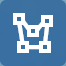
</div>

2. Mark it with the select button and save it with via the save button:

<div>
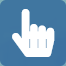
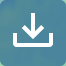
</div>

This method requires that the Poseidon Viewer is running in this SciServer container.

#### Or: 

2. Copy the region from the Poseidon Viewer and paste it in the cell below via the copy to clipboard button:

<div>
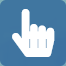
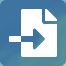
</div>

An example appears in the commented line below. This method works using the Poseidon Viewer app in the SciServer container, or in the standalone version.

The `oceanspy` `viewer_to_range()` function converts the JSON object from the Poseidon-viewer to a `list` that's ready for `oceanspy`.

In [4]:
from poseidon_viewer import get_shapes
import json, jmespath
# shapes = json.loads(get_shapes())

# p1 = jmespath.search('features[?geometry.type==\'Polygon\'].{type:geometry.type, coordinates:geometry.coordinates,timeFrom:properties.timeFrom,timeTo:properties.timeTo}', shapes)
# this_time = p1[0]['timeFrom'][:-1]
# lons, lats = viewer_to_range(p1)

In [5]:
if OGCM_dataset == 'LLC4320':
    # This example cutout is Cape Farewell.
    p1 = [{"type":"Polygon","coordinates":[[[-44.9815202192827,60.09104055159875],[-42.63092318448156,60.13212695522438],[-41.700072317412435,59.26809261134315],[-43.557810465494825,58.65165442845287],[-45.483097885594255,59.264586831593476],[-44.9815202192827,60.09104055159875]]]}]
    this_time = ['2012-04-28T00','2012-04-28T12']
elif OGCM_dataset == 'ECCO':
    # This example cutout is the Labrador Sea.
    p1 = [{"type":"Polygon","coordinates":[[[-64.69568287242545,60.644686293617895],[-52.30523404208099,65.0579427213103],[-43.52739276308005,59.787308855865604],[-55.58977624141812,53.29486558228717],[-62.97805277506514,55.852376703159706],[-64.69568287242545,60.644686293617895]]]}]
    this_time = ['2000-01-01T00','2019-01-01T00']
lons, lats = viewer_to_range(p1)

extracting Polygon


In [6]:
# Cutout region of interest. This makes a rough cutout of the supplied region, bounded by a (lon,lat) rectangle.
cutout_kwargs = {
    'varList': varList,
    'timeRange': this_time,
    'XRange': lons, 
    'YRange': lats, 
    'add_Hbdr': True,
}
cut_od = od.subsample.cutout(**cutout_kwargs)

Cutting out the oceandataset.
faces in the cutout [2, 6, 10]


### Compute accurate mask from Poseidon-viewer cutout polygon.

This code is based on work by Joan Bonilla Pagan.

In [7]:
mxx = cut_od.dataset['XC'].values
myy = cut_od.dataset['YC'].values
points = np.array([Point(x,y) for x, y in zip(mxx.ravel(),myy.ravel())],dtype=object)
pv_cutout0 = [(x, y) for x, y in zip(lons, lats)]
pv_cutout = Polygon(pv_cutout0)
# Make a mask of booleans (True,False)
maskb = np.array([pv_cutout.contains(point) for point in points])
maskb = maskb.reshape(mxx.shape)
# Expand mask in the vertical direction
maskb = maskb[:,:,np.newaxis]
maskb = np.tile(maskb,(1,1,cut_od.dataset['Z'].size))
# Convert booleans into 1s and 0s
maski = maskb.astype(int)
# Convert the 1s and 0s into NaNs
maskn = np.where(maski==1,maski,np.nan)
maskcn = np.where(maski==0,maski,np.nan)
# Create an xarray dataset of the masks
mask = xr.Dataset(
    {
        "maskb": (("Y","X","Z"),maskb),        # Boolean
        "maski": (("Y","X","Z"),maski),        # Integer (1/0)
        "maskn": (("Y","X","Z"),maskn),        # NaNs for cutout
        "maskcn": (("Y","X","Z"),maskcn),      # NaNs for complement of the cutout
    }
)

### Plot the cutout location as a sanity check.

Two versions of the plot are shown: Geographic coordinates (left) and grid cell coordinates (right). The specified cutout is in blue, and the nearest model grid cells are in red. 

Sometimes the geographic coordinates plot fails, especially if face 6 (Arctic) is involved. We trap that error.

The cutout dataset has NaNs in its (XC,YC) coordinates, which causes the horizontal_section plot to fail. Usually, this occurs because face 6 (Arctic) is involved in the cutout. To avoid the error, reduce the size of the cutout. Otherwise, rely on grid point coordinates to visualize the section.


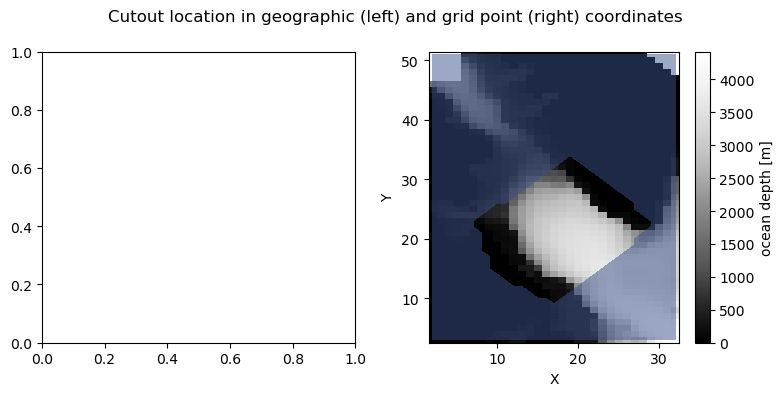

In [8]:
# Make plots.
plt.rcParams["figure.figsize"] = [8,4]      # Adjust the plot aspect ratio here.
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Cutout location in geographic (left) and grid point (right) coordinates')

# Left hand plot in geographic space (use_coords=True). Sometimes this errors, so trap that.
try:
    cut_od.plot.horizontal_section(ax=ax1,varName="Depth", cmap='Greys_r', use_coords=True)
    ax1.plot(lons, lats, 'bo-', label='Specified cutout polygon (geographic coordinates)')
    ax1.legend()

except ValueError:
    print("The cutout dataset has NaNs in its (XC,YC) coordinates, which causes the horizontal_section plot to fail. Usually, this occurs because face 6 (Arctic) is involved in the cutout. To avoid the error, reduce the size of the cutout. Otherwise, rely on grid point coordinates to visualize the section.")

# Right hand plot in index space (use_coords=False).
cut_od.plot.horizontal_section(ax=ax2,varName="Depth", cmap='Greys_r', use_coords=False)
ax2.pcolormesh(cut_od.dataset.X,cut_od.dataset.Y,cut_od.dataset.Depth,cmap='Greys_r')
ax2.contourf(cut_od.dataset['X'],cut_od.dataset['Y'],mask['maskcn'][:,:,1],alpha=0.5)

### Plot SST, SSS, SSH:

Mark the supplied cutout region by masking the peripheral parts

Cutting out the oceandataset.
Computing weighted_mean.


2024-01-04 12:50:48,283 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:34525 -> tcp://127.0.0.1:46037
Traceback (most recent call last):
  File "/home/idies/mambaforge/envs/Oceanography/lib/python3.10/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
  File "/home/idies/mambaforge/envs/Oceanography/lib/python3.10/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/idies/mambaforge/envs/Oceanography/lib/python3.10/site-packages/distributed/worker.py", line 1778, in get_data
    response = await comm.read(deserializers=serializers)
  File "/home/idies/mambaforge/envs/Oceanography/lib/python3.10/site-packages/distributed/comm/tcp.py", line 241, in read
    convert_stream_closed_error(s

Computing weighted_mean.


/home/idies/mambaforge/envs/Oceanography/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Computing weighted_mean.


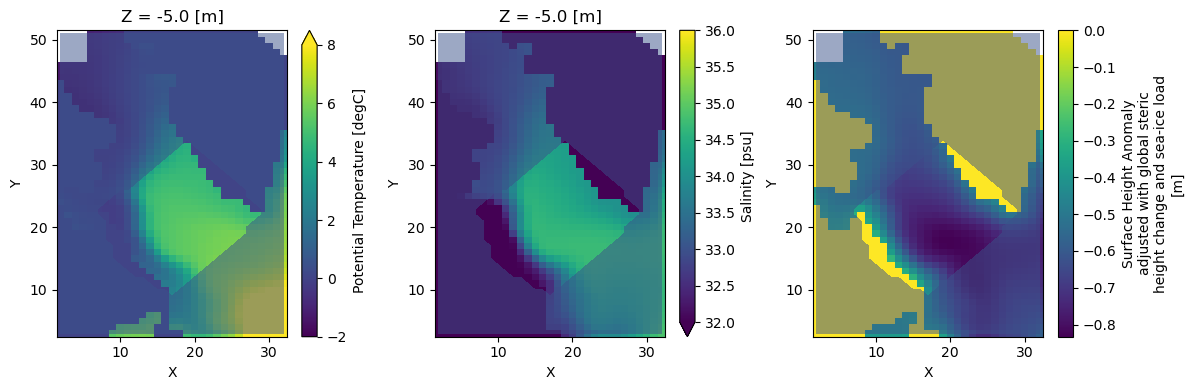

In [9]:
plt.rcParams["figure.figsize"] = [12,4]      # Adjust the plot aspect ratio here.
fig, (ax3,ax4,ax5) = plt.subplots(1,3)
cut_od2 = cut_od.subsample.cutout(ZRange = 0, add_Hbdr=False)
cut_od2.plot.horizontal_section(ax=ax3,varName='Temp',use_coords=False,vmin = -2, vmax = 8,meanAxes='time')
ax3.contourf(cut_od2.dataset['X'],cut_od2.dataset['Y'],mask['maskcn'][:,:,1],alpha=0.5)
cut_od2.plot.horizontal_section(ax=ax4,varName='S',vmin=32,vmax=36,use_coords=False,meanAxes='time')
ax4.contourf(cut_od2.dataset['X'],cut_od2.dataset['Y'],mask['maskcn'][:,:,1],alpha=0.5)
cut_od2.plot.horizontal_section(ax=ax5,varName='Eta',use_coords=False,meanAxes='time')
ax5.contourf(cut_od2.dataset['X'],cut_od2.dataset['Y'],mask['maskcn'][:,:,1],alpha=0.5)

### Compute and plot dynamical quantities:

In [10]:
# Compute potential density, buoyancy frequency, vertical relative vorticity, and Ertel PV:
cut_od = cut_od.compute.potential_density_anomaly()
cut_od = cut_od.compute.Brunt_Vaisala_frequency()
cut_od = cut_od.compute.vertical_relative_vorticity()
cut_od = cut_od.compute.Ertel_potential_vorticity()

Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
Computing Brunt-Väisälä Frequency using the following parameters: {'rho0': 1027, 'g': 9.81}.
Computing gradient.
Computing vertical component of relative vorticity.
Computing curl.
Computing relative vorticity.
Computing curl.
Computing gradient.
Computing missing horizontal spacing.
Computing gradient.
Computing gradient.
Computing gradient.
Computing missing horizontal spacing.
Computing Ertel potential vorticity using the following parameters: {'rho0': 1027, 'g': 9.81, 'omega': 7.292123516990375e-05}.
Computing gradient.
Computing missing horizontal spacing.
Computing missing horizontal spacing.


In [11]:
# Cutout data for plotting: Select depth horizon for the horizontal section plots here.
depth_for_plots = -50.0    # m
cut_od4 = cut_od.subsample.cutout(ZRange = depth_for_plots,add_Hbdr=True)

Cutting out the oceandataset.


Computing weighted_mean.


/home/idies/mambaforge/envs/Oceanography/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Computing weighted_mean.


/home/idies/mambaforge/envs/Oceanography/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/idies/mambaforge/envs/Oceanography/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/idies/mambaforge/envs/Oceanography/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/idies/mambaforge/envs/Oceanography/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Computing weighted_mean.
Computing weighted_mean.


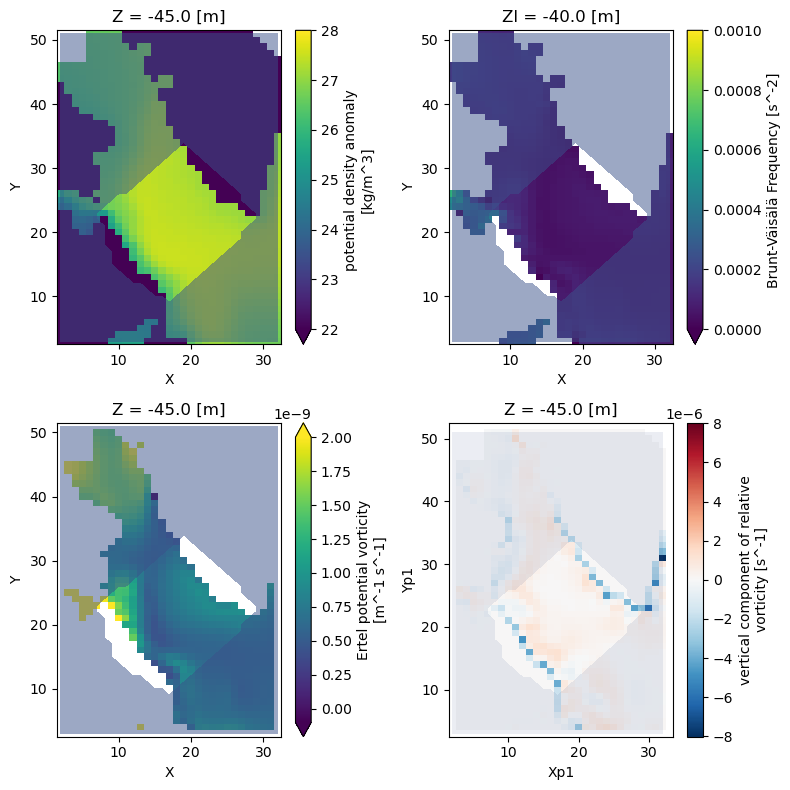

In [12]:
# Plot figures:
plt.rcParams["figure.figsize"] = [8,8]      # Adjust the plot aspect ratio here.
fig, ((ax6,ax7),(ax8,ax9)) = plt.subplots(2, 2)

cut_od4.plot.horizontal_section(ax=ax6,varName='Sigma0',vmin=22,vmax=28,use_coords=False,meanAxes='time')
ax6.contourf(cut_od4.dataset['X'],cut_od4.dataset['Y'],mask['maskcn'][:,:,1],alpha=0.5)
cut_od4.plot.horizontal_section(ax=ax7,varName='N2',vmin=0,vmax=1e-3,use_coords=False,meanAxes='time')
ax7.contourf(cut_od4.dataset['X'],cut_od4.dataset['Y'],mask['maskcn'][:,:,1],alpha=0.5)
cut_od4.plot.horizontal_section(ax=ax8,varName='Ertel_PV',vmin=-1e-10,vmax=2e-9,use_coords=False,meanAxes='time')
ax8.contourf(cut_od4.dataset['X'],cut_od4.dataset['Y'],mask['maskcn'][:,:,1],alpha=0.5)
cut_od4.plot.horizontal_section(ax=ax9,varName='momVort3',use_coords=False,meanAxes='time')
ax9.contourf(cut_od4.dataset['X'],cut_od4.dataset['Y'],mask['maskcn'][:,:,1],alpha=0.1)

### Now mask the rough cutout dataset using the accurate Poseidon-viewer polygon cutout

Use a lower `Z` limit of `lower_Z_lim` for the depth of the accurate cutout to isolate the upper ocean.

In [13]:
lower_Z_lim = -200.0  # m: depth of lower limit of cutout.
cut_od._ds['mask_integrand'] = mask['maski']*cut_od.dataset['HFacC'].where(cut_od.dataset['Z'] > lower_Z_lim)
cut_od._ds['m_temp'] = cut_od.dataset['Temp'][:]*mask['maski']
cut_od._ds['m_temp'] = cut_od._ds['m_temp'].where(cut_od.dataset['Z'] > lower_Z_lim)
cut_od._ds['m_S'] = cut_od.dataset['S'][:]*mask['maski']
cut_od._ds['m_S'] = cut_od._ds['m_S'].where(cut_od.dataset['Z'] > lower_Z_lim)

### Now integrate temperature and salinity over the cutout region:
Also compute surface area of the cutout (at different depths) and its volume.

In [14]:
cut_od = cut_od.compute.integral(varNameList =  'mask_integrand',                 axesList = ['X','Y']) 
cut_od = cut_od.compute.integral(varNameList = ['mask_integrand','m_temp','m_S'], axesList = ['X','Y','Z'])

Computing integral.
Computing integral.


### Plot figures of the timeseries of the cutout-volume-integrated temperature and salinity, namely the heat and salt mass content:

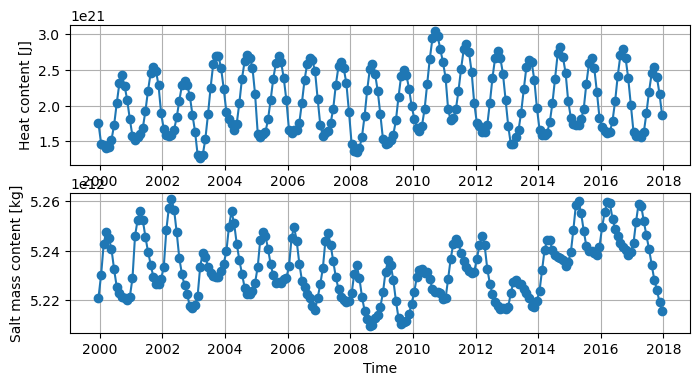

In [15]:
plt.rcParams["figure.figsize"] = [8,4]      # Adjust the plot aspect ratio here.
fig, (ax10,ax11) = plt.subplots(2, 1)

# Constants to compute variables for plotting:
rho_0 = 1025.0  # kg/m^3: Reference density
c_p = 3986.0   # J/kg/K: Specific heat capacity
gkg_to_kgkg = 1.0e-3  # Conversion factor for salinity in g/kg to kg/kg

plt.subplot(2, 1, 1)
plt.plot(cut_od.dataset['time'],cut_od.dataset['I(m_temp)dXdYdZ']*rho_0*c_p,'o-')
plt.ylabel('Heat content [J]')
plt.grid()

plt.subplot(2,1, 2)
plt.plot(cut_od.dataset['time'],cut_od.dataset['I(m_S)dXdYdZ']*gkg_to_kgkg,'o-')
plt.ylabel('Salt mass content [kg]')
plt.xlabel('Time')
plt.grid()

Report information on the size of the accurate cutout:

In [16]:
print(f" Surface area of Poseidon-volume cutout (excluding land                  ): {cut_od.dataset['I(mask_integrand)dXdY'].values[0]:8.4e} m^2")
print(f" Volume       of Poseidon-volume cutout (excluding land, down to {lower_Z_lim:7.1f}m): {cut_od.dataset['I(mask_integrand)dXdYdZ'].values:8.4e} m^3")

 Surface area of Poseidon-volume cutout (excluding land                  ): 7.8447e+11 m^2
 Volume       of Poseidon-volume cutout (excluding land, down to  -200.0m): 1.5175e+14 m^3


#### For ideas on how to continue the data analysis, see the Quick Start, Tutorial, and Use Case notebooks at [oceanspy.readthedocs.io](https://oceanspy.readthedocs.io/en/latest/index.html)